# Nonlinear classifiers
## Answer: 
### 1. Logistic regression baseline performs better than random forest, linear SVM and RBF SVM at 2-4% better accuracy after tuning the hyperparameters of random forest, linear SVM and RBF SVM.

### 2.
### Random forest: Test accuracy = 94%
### SVM Linear: Test accuracy = 92%
### SVM RBF: Test accuracy = 92%

## 1. Import necessary libaries and datasets.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt

with np.load('trainfeature.npz', allow_pickle=False) as npz_file:
    traindata = dict(npz_file.items())

X_tr = traindata['features']
y_tr = traindata['targets']

with np.load('validfeature.npz', allow_pickle=False) as npz_file:
    validdata = dict(npz_file.items())

X_va = validdata['features']
y_va = validdata['targets']

with np.load('testfeature.npz', allow_pickle=False) as npz_file:
    testdata = dict(npz_file.items())

X_te = testdata['features']
y_te = testdata['targets']

## 2. Random forest with increasing number of trees
### Answer: Yes, the number of trees do increase the accuracy of the classifaction.

In [2]:
t_values = np.r_[1, np.arange(5, 200, step=10)]
cv_values = np.r_[np.arange(2,13,step=1)]

rf_pipe = Pipeline([
    ('rf', RandomForestClassifier(n_estimators=1, max_depth=None, random_state=0))
])

gs_results = []

for t in t_values:
    # Fit random forest model
    rf_pipe.set_params(rf__n_estimators=t)
    for cvalue in cv_values:
        tr_score = cross_validate(rf_pipe, X_tr, y_tr, cv=cvalue)
        va_score = cross_validate(rf_pipe, X_va, y_va, cv=cvalue)
        # Save model and its performance on train/test sets
        gs_results.append({
            'tree number': t,
            'CV folds': cvalue,
            'train_accuracy': np.mean(tr_score['test_score']),
            'valid_accuracy': np.mean(va_score['test_score'])
        })
    
gs_results = pd.DataFrame(gs_results)
gs_results.sort_values(by='valid_accuracy', ascending=False).head()

,CV folds,train_accuracy,tree number,valid_accuracy
115,7,0.871669,95,0.909550
148,7,0.861204,125,0.896254
159,7,0.857445,135,0.896254
170,7,0.861283,145,0.896254
181,7,0.864855,155,0.896254


### Observation: Using CV k-folds of 7 has the highest validation accuracy for tree number = 95.

In [3]:
rf = RandomForestClassifier(n_estimators=95, max_depth=None, random_state=0)
#combine test and validation datasets
X = np.concatenate((X_tr,X_va),axis=0)
y = np.concatenate((y_tr,y_va),axis=0)

rf.fit(X,y)
print('Test accuracy of random forest',rf.score(X_te,y_te))

Test accuracy of random forest 0.94


## 3. Comparison of SVM for linear and RBF kernel perform better than the linear.
 - I compare both classifiers within a range of different regularization strengths. 

Test accuracy of linear SVM 0.9219891219891221
Test accuracy of RBF SVM 0.9219891219891221


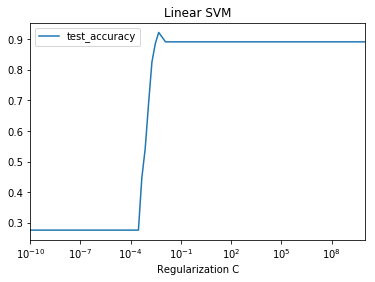

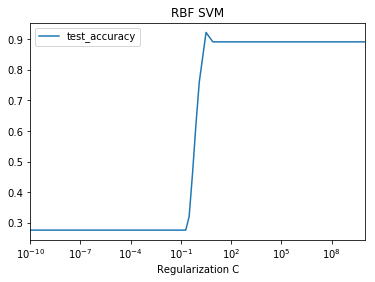

In [4]:
# Populate regularization strength inputs
C_reg = np.logspace(-10, 10, num=100)

# initialize results container
C_linear_results = []
C_rbf_results = []
for c in C_reg:
    # initialise linear SVM classifer with different regularization strength
    linear_svc = SVC(C=c,kernel='linear').fit(X_tr, y_tr)
    linear_tr_score = cross_validate(linear_svc, X_tr, y_tr, cv=5)
    linear_va_score = cross_validate(linear_svc, X_va, y_va, cv=5)
    linear_te_score = cross_validate(linear_svc, X_te, y_te, cv=5)
    # initialise RBF SVM classifer with different regularization strength
    rbf_svc = SVC(C=c,kernel='rbf',gamma='auto').fit(X_tr, y_tr)
    rbf_tr_score = cross_validate(rbf_svc, X_tr, y_tr, cv=5)
    rbf_va_score = cross_validate(rbf_svc, X_va, y_va, cv=5)
    rbf_te_score = cross_validate(rbf_svc, X_te, y_te, cv=5)
    C_linear_results.append({
        'Regularization C': c,        
        'train_accuracy': np.mean(linear_tr_score['test_score']),
        'valid_accuracy': np.mean(linear_va_score['test_score']),
        'test_accuracy': np.mean(linear_te_score['test_score'])
    })
    C_rbf_results.append({
        'Regularization C': c,        
        'train_accuracy': np.mean(rbf_tr_score['test_score']),
        'valid_accuracy': np.mean(rbf_va_score['test_score']),
        'test_accuracy': np.mean(rbf_te_score['test_score'])
    })
    
    
C_linear_results = pd.DataFrame(C_linear_results)
C_rbf_results = pd.DataFrame(C_rbf_results)

C_linear_results.plot(x='Regularization C',y='test_accuracy',title='Linear SVM',logx=True)
C_rbf_results.plot(x='Regularization C',y='test_accuracy',title='RBF SVM',logx=True)
print('Test accuracy of linear SVM',np.max(C_linear_results['test_accuracy']))
print('Test accuracy of RBF SVM',np.max(C_rbf_results['test_accuracy']))

## 4. Accuracy differences between linear and RBF kernels of SVM as the function of regularization strength.

Observation: Linear SVM performs better than RBF SVM when the regularization strength has the value of 1E-3 < C < 1E-1. Then their accuracies start to converge respectively at higher regularization strengths.

Text(0.5, 0, 'Regularization Strength, C')

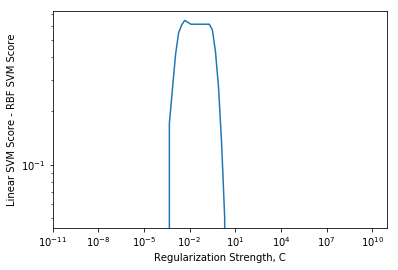

In [5]:
dif = C_linear_results['test_accuracy']-C_rbf_results['test_accuracy']

plt.plot(C_reg,dif)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Linear SVM Score - RBF SVM Score')
plt.xlabel('Regularization Strength, C')